In [1]:
import scipy.io
import numpy as np

from datetime import datetime, timedelta
import time

import tensorflow as tf

import keras
from keras.preprocessing import image
from keras.callbacks import ModelCheckpoint,EarlyStopping
from keras.layers import Dense, Activation, Dropout, Flatten, Input, Convolution2D, ZeroPadding2D, MaxPooling2D, Activation
from keras.layers import Conv2D, AveragePooling2D
from keras.models import Model, Sequential
from keras import metrics
from keras.models import model_from_json

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

import cv2

import pandas as pd
"""import ray
ray.init(plasma_directory="/workspaces/96273/temp")
import modin.pandas as pd"""

Using TensorFlow backend.


'import ray\nray.init(plasma_directory="/workspaces/96273/temp")\nimport modin.pandas as pd'

In [2]:
#if you have multiple GPUs, use this block to avoid allocate all GPUs and all memory.

import os
os.environ["CUDA_VISIBLE_DEVICES"]="1"

import tensorflow as tf
from keras import backend as K
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.Session(config=config)
K.set_session(session)

In [4]:
#VGG-Face for face recognition: https://sefiks.com/2018/08/06/deep-face-recognition-with-keras/

def loadVggFaceModel():
    model = Sequential()
    model.add(ZeroPadding2D((1,1),input_shape=(224,224, 3)))
    model.add(Convolution2D(64, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(128, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(Convolution2D(4096, (7, 7), activation='relu'))
    model.add(Dropout(0.5))
    model.add(Convolution2D(4096, (1, 1), activation='relu'))
    model.add(Dropout(0.5))
    model.add(Convolution2D(2622, (1, 1)))
    model.add(Flatten())
    model.add(Activation('softmax'))
    
    vgg_face_descriptor = Model(inputs=model.layers[0].input, outputs=model.layers[-2].output)
    
    return vgg_face_descriptor

In [5]:
model = loadVggFaceModel()

In [6]:
#you can download pretrained weights from https://drive.google.com/file/d/1CPSeum3HpopfomUEK1gybeuIVoeJT_Eo/view?usp=sharing
from keras.models import model_from_json
model.load_weights('vgg_face_weights.h5')

In [7]:
#open-cv's face detection module
face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')

# Read meta data

In [8]:
# Ref https://data.vision.ee.ethz.ch/cvl/rrothe/imdb-wiki/
# https://data.vision.ee.ethz.ch/cvl/rrothe/imdb-wiki/static/imdb_crop.tar
mat = scipy.io.loadmat('imdb_crop/imdb.mat')

In [9]:
columns = ["dob", "photo_taken", "full_path", "gender", "name", "face_location", "face_score", "second_face_score", "celeb_names", "celeb_id"]

In [10]:
instances = mat['imdb'][0][0][0].shape[1]

In [11]:
df = pd.DataFrame(index = range(0,instances), columns = columns)

In [12]:
df.shape

(460723, 10)

In [13]:
for i in mat:
    if i == "imdb":
        current_array = mat[i][0][0]
        for j in range(len(current_array)):
            #print(j,". ",columns[j],": ",current_array[j][0])
            df[columns[j]] = pd.DataFrame(current_array[j][0])

In [14]:
df.head()

,dob,photo_taken,full_path,gender,name,face_location,face_score,second_face_score,celeb_names,celeb_id
0,693726,1968,[01/nm0000001_rm124825600_1899-5-10_1968.jpg],1.0,[Fred Astaire],"[[1072.926, 161.838, 1214.7839999999999, 303.6...",1.459693,1.118973,['Lee' George Quinones],6488
1,693726,1970,[01/nm0000001_rm3343756032_1899-5-10_1970.jpg],1.0,[Fred Astaire],"[[477.184, 100.352, 622.592, 245.76]]",2.543198,1.852008,['Weird Al' Yankovic],6488
2,693726,1968,[01/nm0000001_rm577153792_1899-5-10_1968.jpg],1.0,[Fred Astaire],"[[114.96964308962852, 114.96964308962852, 451....",3.455579,2.985660,[2 Chainz],6488
3,693726,1968,[01/nm0000001_rm946909184_1899-5-10_1968.jpg],1.0,[Fred Astaire],"[[622.8855056426588, 424.21750383700805, 844.3...",1.872117,NaN,[50 Cent],6488
4,693726,1968,[01/nm0000001_rm980463616_1899-5-10_1968.jpg],1.0,[Fred Astaire],"[[1013.8590023603723, 233.8820422075853, 1201....",1.158766,NaN,[A Martinez],6488


In [15]:
#remove pictures does not include face
df = df[df['face_score'] != -np.inf]

#some pictures include more than one face, remove them
df = df[df['second_face_score'].isna()]

#check threshold
df = df[df['face_score'] >= 3]

In [16]:
df.shape #95234

(95234, 10)

In [17]:
def extractNames(name):
    return name[0]

In [18]:
df['celebrity_name'] = df['name'].apply(extractNames)

In [19]:
df.shape

(95234, 11)

In [20]:
#df = df.drop(columns = ['dob', 'photo_taken', 'face_location', 'face_score', 'second_face_score'])

# Load data set images

In [21]:
def getImagePixels(image_path):
    return cv2.imread("imdb_crop/%s" % image_path[0]) #pixel values in scale of 0-255

In [22]:
tic = time.time()
df['pixels'] = df['full_path'].apply(getImagePixels)
toc = time.time()

print("this block completed in ",toc-tic," seconds...") #562.80 seconds

this block completed in  150.7494854927063  seconds...


# Represent images as vectors

In [54]:
def findFaceRepresentation(img):
    detected_face = img
    #plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    
    #-----------------------------
    """
    faces = face_cascade.detectMultiScale(img, 1.3, 5)

    for (x,y,w,h) in faces:
        detected_face = img[int(y):int(y+h), int(x):int(x+w)]

        try:
            margin = 10
            margin_x = int((w * margin)/100); margin_y = int((h * margin)/100)
            detected_face = img[int(y-margin_y):int(y+h+margin_y), int(x-margin_x):int(x+w+margin_x)]
        except:
            print("detected face has no margin")
    """
    #-----------------------------
    
    try: 
        detected_face = cv2.resize(detected_face, (224, 224))
        #plt.imshow(cv2.cvtColor(detected_face, cv2.COLOR_BGR2RGB))
        
        #normalize detected face in scale of -1, +1

        img_pixels = image.img_to_array(detected_face)
        img_pixels = np.expand_dims(img_pixels, axis = 0)
        img_pixels /= 127.5
        img_pixels -= 1
        
        representation = model.predict(img_pixels)[0,:]
    except:
        representation = None
        
    return representation  

In [55]:
tic = time.time()
df['face_vector_raw'] = df['pixels'].apply(findFaceRepresentation) #vector for raw image
toc = time.time()

print("this block completed in ",toc-tic," seconds...")

this block completed in  669.214102268219  seconds...


# Load Your Photo

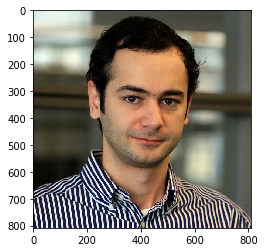

In [203]:
img = cv2.imread("sefik.jpg") #pixel values in scale of 0-255
#img = cv2.imread("sefik_2.jpg") #pixel values in scale of 0-255

plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

faces = face_cascade.detectMultiScale(img, 1.3, 5)

for (x,y,w,h) in faces:
    detected_face = img[int(y):int(y+h), int(x):int(x+w)]
    
    #cv2.rectangle(img,(x,y),(x+w,y+h),(128,128,128),cv2.FILLED)
    #plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    
    #add 15% margin around the face
    try:
        margin = 10
        margin_x = int((w * margin)/100); margin_y = int((h * margin)/100)
        detected_face = img[int(y-margin_y):int(y+h+margin_y), int(x-margin_x):int(x+w+margin_x)]
    except:
        print("detected face has no margin")
    
    detected_face = cv2.resize(detected_face, (224, 224))

#plt.imshow(detected_face)
#plt.imshow(cv2.cvtColor(detected_face, cv2.COLOR_BGR2RGB))

In [175]:
img_pixels = image.img_to_array(detected_face)
img_pixels = np.expand_dims(img_pixels, axis = 0)
img_pixels /= 127.5
img_pixels -= 1

In [176]:
yourself_representation = model.predict(img_pixels)[0,:]

# Find Similarities

In [177]:
def findCosineSimilarity(source_representation, test_representation=yourself_representation):
    try:
        a = np.matmul(np.transpose(source_representation), test_representation)
        b = np.sum(np.multiply(source_representation, source_representation))
        c = np.sum(np.multiply(test_representation, test_representation))
        return 1 - (a / (np.sqrt(b) * np.sqrt(c)))
    except:
        return 10 #assign a large value. similar faces will have small value.

In [178]:
df['similarity'] = df['face_vector_raw'].apply(findCosineSimilarity)

In [179]:
df = df.sort_values(by=['similarity'], ascending=True)

In [72]:
"""x = df.iloc[0]['pixels'].reshape(224, 224, 3)/255
plt.imshow(x)"""

"x = df.iloc[0]['pixels'].reshape(224, 224, 3)/255\nplt.imshow(x)"

In [205]:
df.head(1)

,dob,photo_taken,full_path,gender,name,face_location,face_score,second_face_score,celeb_names,celeb_id,celebrity_name,pixels,face_vector,similarity,face_vector_raw
360550,725915,2007,[53/nm2067953_rm40799744_1987-6-27_2007.jpg],1.0,[Ed Westwick],"[[132.2873182770776, 88.43887885138507, 263.09...",5.381315,NaN,NaN,5517,Ed Westwick,"[[[177, 168, 171], [175, 166, 169], [171, 164,...","[0.01662558, 0.0017614793, 0.027104639, 0.0186...",0.257118,"[0.009625799, -0.0071645407, 0.026974356, 0.04..."


In [ ]:
#df = df.reset_index()

0 . Ed Westwick  ( 0.25711774826049805 ) -  53/nm2067953_rm40799744_1987-6-27_2007.jpg


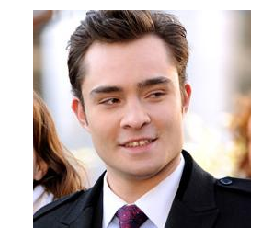

-------------------------
1 . Ed Westwick  ( 0.2586429715156555 ) -  53/nm2067953_rm57576960_1987-6-27_2007.jpg


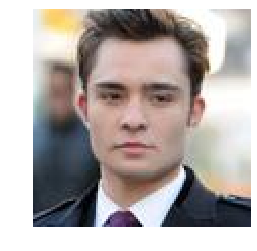

-------------------------
2 . Currie Graham  ( 0.26789337396621704 ) -  82/nm0333982_rm2450766336_1967-2-26_2011.jpg


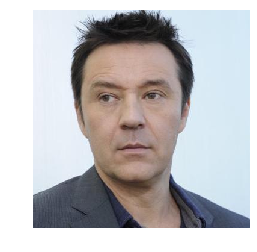

-------------------------
3 . Joshua Jackson  ( 0.2687184810638428 ) -  45/nm0005045_rm248026112_1978-6-11_2008.jpg


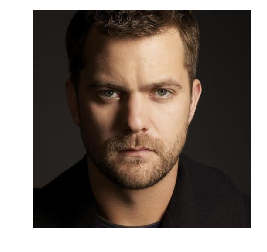

-------------------------
4 . Colin Hanks  ( 0.26892513036727905 ) -  88/nm0004988_rm762101504_1977-11-24_2006.jpg


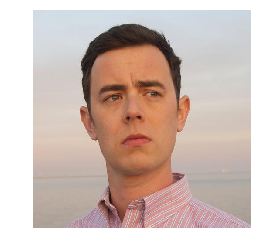

-------------------------
5 . Ed Westwick  ( 0.26984667778015137 ) -  53/nm2067953_rm2545855488_1987-6-27_2007.jpg


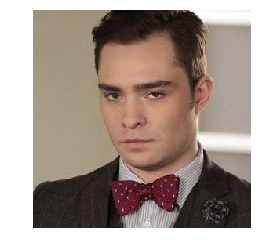

-------------------------
6 . Colin Hanks  ( 0.270976722240448 ) -  88/nm0004988_rm2097516288_1977-11-24_2010.jpg


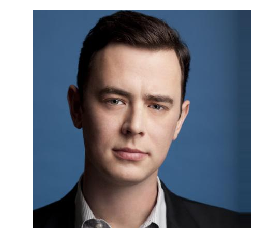

-------------------------


In [210]:
#this block might show different pictures of same actors
if True:
    for i in range(0, 7):
        instance = df.iloc[i]
        name = instance['celebrity_name']
        similarity = instance['similarity']
        
        #img = instance['pixels']
        full_path = instance['full_path'][0]
        img = cv2.imread("imdb_crop/%s" % full_path)
        
        print(i,".",name," (",similarity,") - ",full_path)

        plt.axis('off')
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        plt.show()

        print("-------------------------")

In [180]:
pivot_df = df.drop_duplicates(subset ="celebrity_name")
pivot_df = pivot_df[pivot_df['photo_taken'] >= 2000]

#0: woman, 1: man. if you know the gender of your target image, then you can filter data set and it fasten system
pivot_df = pivot_df[pivot_df['gender'] == 1]

pivot_df = pivot_df.reset_index()

Ed Westwick  ( 74.2882251739502 %) -  53/nm2067953_rm40799744_1987-6-27_2007.jpg


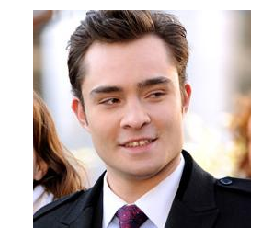

-------------------------
Currie Graham  ( 73.2106626033783 %) -  82/nm0333982_rm2450766336_1967-2-26_2011.jpg


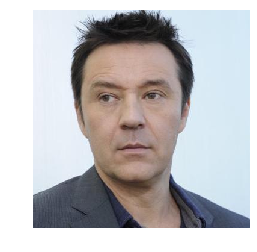

-------------------------
Joshua Jackson  ( 73.12815189361572 %) -  45/nm0005045_rm248026112_1978-6-11_2008.jpg


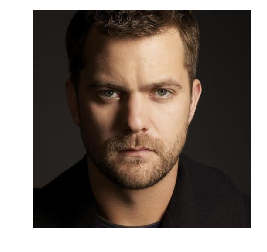

-------------------------
Colin Hanks  ( 73.1074869632721 %) -  88/nm0004988_rm762101504_1977-11-24_2006.jpg


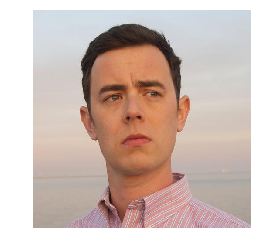

-------------------------


In [206]:
for i in range(0, 4):
    instance = pivot_df.iloc[i]
    name = instance['celebrity_name']
    similarity = instance['similarity']
    
    similarity = (1 - similarity)*100
    
    #img = instance['pixels']
    full_path = instance['full_path'][0]
    img = cv2.imread("imdb_crop/%s" % full_path)
    
    print(name," (",similarity,"%) - ",full_path)
    
    plt.axis('off')
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.show()
    
    print("-------------------------")

37 .  Jim Parsons  ( 67.05468893051147 ) -  88/nm1433588_rm3339561216_1973-3-24_2012.jpg


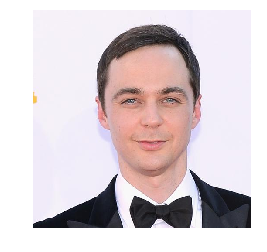

In [209]:
#you can check a specific celebrity
target = pivot_df[pivot_df['celebrity_name'] == 'Jim Parsons']

for index, instance in target.iterrows():
    name = instance['celebrity_name']
    similarity = instance['similarity']
    full_path = instance['full_path'][0]

    similarity = (1 - similarity)*100
    
    print(index,". ", name," (",similarity,") - ",full_path)

    img = cv2.imread("imdb_crop/%s" % full_path)
    
    plt.axis('off')
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.show()